In [1]:
import pyemma.coordinates as coords
import mdtraj as md
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import pairwise_distances_argmin
import sklearn

from math import sqrt
import sys
import os

from datetime import date
from subprocess import call

In [2]:
#trajfile = 'C:\\Users\\data\\DESRES-Trajectory_sarscov2-10880334-no-water-no-ion-glueCA\\sarscov2-10880334-no-water-no-ion-glueCA\\sarscov2-10880334-no-water-no-ion-glueCA-0000.dcd'
#topfile = 'C:\\Users\\data\\DESRES-Trajectory_sarscov2-10880334-no-water-no-ion-glueCA\\sarscov2-10880334-no-water-no-ion-glueCA\\DESRES-Trajectory_sarscov2-10880334-no-water-no-ion-glueCA.pdb'
project_dir = os.path.dirname(os.getcwd()) +"\\data\\"

C:\Users\data\


In [3]:
traj = md.load(trajfile[:],  stride = 1, top = topfile)
feat = coords.featurizer(topfile)
# just use all xyz-coordinates
feat.add_all()

In [4]:
inp = coords.source(trajfile, feat)

# TICA

In [37]:
 def optimal_number_of_clusters(wcss):
    # Function to define the optimal number of clusters
    x1, y1 = 1, wcss[0]
    x2, y2 = 100, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

   pc_id  eig_cum  eig_values
0      0      0.5         1.0
1      1      1.0        -1.0


C:\Users\Mondello\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


13


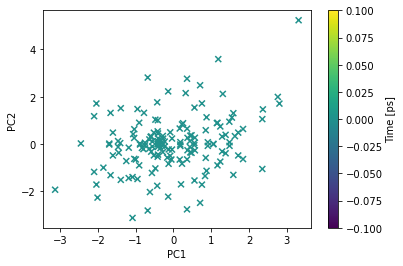

In [39]:
lag=100
tica_obj = coords.tica(inp, lag=lag, dim=2, kinetic_map=True)
# here we get the data that has been projected onto the first 2 IC's. It's a list, because we could generally
# have a list of trajectories, so we just get the first element.
Y = tica_obj.get_output()[0]
tica_components = tica_obj.fit_transform(Y) * -1
tica_components_df = pd.DataFrame(tica_components)
tica_eigenvalues = tica_obj.eigenvalues
pc_id = list(range(len(tica_eigenvalues)))
tica_eigen_df = pd.DataFrame({"pc_id": pc_id, "eig_cum": tica_obj.cumvar, "eig_values": tica_eigenvalues})
print(tica_eigen_df)
n_tica = tica_eigen_df[tica_eigen_df['eig_cum'] <= 2]
n_tica = n_tica.shape[0]
tica_components_df = pd.DataFrame(tica_components)
X = tica_components_df.iloc[:,:n_tica]
X.shape
inertias = []
K = range(1, 100)

for k in K:
    model = KMeans(n_clusters = k, random_state = 100)
    model.fit(X)
    inertias.append(model.inertia_)
    
n = optimal_number_of_clusters(inertias)    
print(n)
plt.figure()
plt.scatter(tica_components[:, 0], tica_components[:,1], marker = 'x', c = traj.time)
plt.xlabel('PC1')
plt.ylabel('PC2')
cbar = plt.colorbar()
cbar.set_label('Time [ps]')

plt.show()

Populating the interactive namespace from numpy and matplotlib


C:\Users\Mondello\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Text(0.5, 0, 'time (1000 ns)')

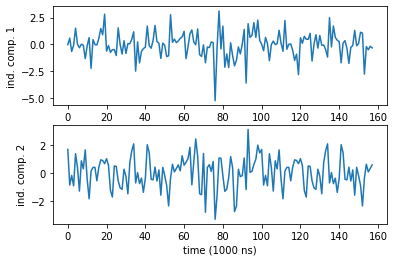

In [6]:
import numpy as np
%pylab inline
subplot2grid((2,1),(0,0))
plot(Y[:,0])
ylabel('ind. comp. 1')
subplot2grid((2,1),(1,0))
plot(Y[:,1])
ylabel('ind. comp. 2')
xlabel('time (1000 ns)')
Text(0.5,0,'time (1000 ns)')

In [7]:
print('Mean values: ', np.mean(Y, axis=0))
print('Variances:   ', np.var(Y, axis=0))

Mean values:  [-0.02666805  0.03576515]
Variances:    [1.3778329 1.2731094]


<ipython-input-8-6dbc62f36095>:4: RuntimeWarning: divide by zero encountered in log
  F = -np.log(z)


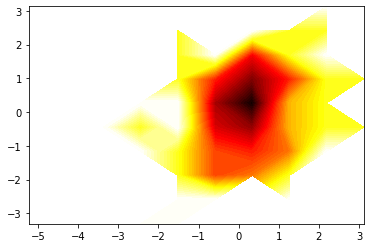

In [8]:
# histogram data
z,x,y = np.histogram2d(Y[:,0],Y[:,1])
# compute free energies
F = -np.log(z)
# contour plot
extent = [x[0], x[-1], y[0], y[-1]]
contourf(F.T,50,cmap=plt.cm.hot, extent=extent)

In [9]:
 def optimal_number_of_clusters(wcss):
    # Function to define the optimal number of clusters
    x1, y1 = 1, wcss[0]
    x2, y2 = 100, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

In [11]:
cl = coords.cluster_kmeans(data=Y, k=100, stride=1)
# for later use we save the discrete trajectories and cluster center coordinates:
dtrajs = cl.dtrajs
cc_x = cl.clustercenters[:,0]
cc_y = cl.clustercenters[:,1]

initialize kmeans++ centers:   0%|                                                             | 0/100 [00:00<…

kmeans iterations:   0%|                                                                        | 0/10 [00:00<…

TypeError: 'KmeansClustering' object is not subscriptable

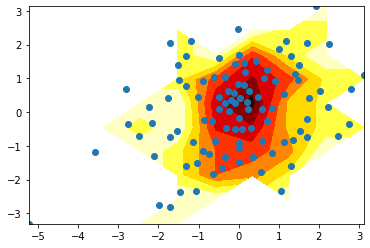

In [12]:
contourf(F.T,cmap=plt.cm.hot, extent=extent)
plot(cc_x,cc_y, linewidth=0, marker='o')

# PCA

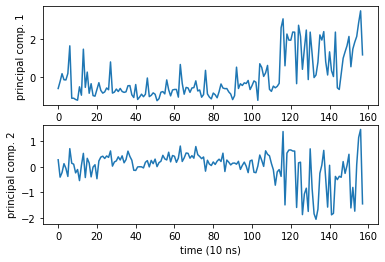

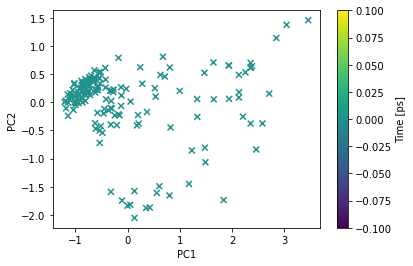

In [17]:
pca_obj = coords.pca(inp, dim=2)
Ypca = pca_obj.get_output()[0]
subplot2grid((2,1),(0,0))
plot(Ypca[:,0])
ylabel('principal comp. 1')
subplot2grid((2,1),(1,0))
plot(Ypca[:,1])
ylabel('principal comp. 2')
xlabel('time (10 ns)')
plt.figure()
plt.scatter(Ypca[:, 0], Ypca[:,1], marker = 'x', c = traj.time)
plt.xlabel('PC1')
plt.ylabel('PC2')
cbar = plt.colorbar()
cbar.set_label('Time [ps]')

plt.show()

In [18]:
def _to_free_energy(z, minener_zero=False):

    pi = z / float(z.sum())
    free_energy = np.inf * np.ones(shape=z.shape)
    nonzero = pi.nonzero()
    free_energy[nonzero] = -np.log(pi[nonzero])

    if minener_zero:
        free_energy[nonzero] -= np.min(free_energy[nonzero])
    return free_energy

def get_histogram(
        xall, yall, nbins = 100,
        weights = None, avoid_zero_count = False):
  
    z, xedge, yedge = np.histogram2d(
        xall, yall, bins = nbins, weights = weights)
    
    x = 0.5 * (xedge[:-1] + xedge[1:])
    y = 0.5 * (yedge[:-1] + yedge[1:])

    if avoid_zero_count:
        z = np.maximum(z, np.min(z[z.nonzero()]))
    return x, y, z.T

In [19]:
x, y, z = get_histogram(pca_components[:,0], pca_components[:,1])

NameError: name 'pca_components' is not defined

(158, 2)


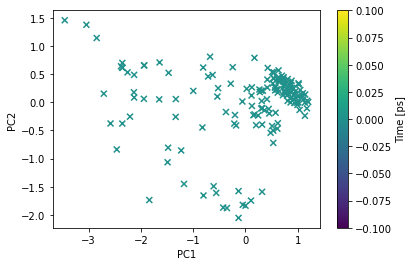

In [20]:
from sklearn.decomposition import PCA

pca_sklearn = PCA(random_state = 100)
pca_components = pca_sklearn.fit_transform(Ypca) * -1
plt.figure()
plt.scatter(pca_components[:, 0], pca_components[:,1], marker = 'x', c = traj.time)
plt.xlabel('PC1')
plt.ylabel('PC2')
cbar = plt.colorbar()
cbar.set_label('Time [ps]')

plt.show()

In [28]:
kT = 1.0
f = _to_free_energy(z, minener_zero =  True) * kT

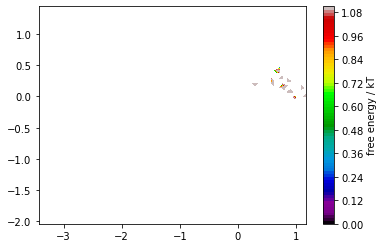

In [29]:
import matplotlib.pyplot as _plt

fig, ax = _plt.subplots()
mappable = ax.contourf(
    x, y, f, 100, norm = None,
    vmin = None, vmax = None, cmap = 'nipy_spectral',
    levels = None)

misc = dict(mappable = mappable)
cbar_ = fig.colorbar(
    mappable, ax = None, orientation = 'vertical')
cbar_.set_label('free energy / kT')

plt.show()

In [30]:
pca_eigenvalues = pca_sklearn.explained_variance_ratio_
pc_id = list(range(len(pca_eigenvalues)))
print(pc_id)
pca_eigen_df = pd.DataFrame({"pc_id": pc_id, "eig_cum": np.cumsum(pca_eigenvalues), "eig_values": pca_eigenvalues})
pca_eigen_df.head()

[0, 1]


,pc_id,eig_cum,eig_values
0,0,0.754647,0.754647
1,1,1.000000,0.245354


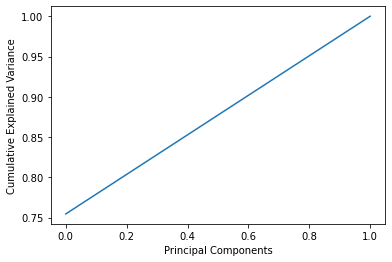

In [31]:
plt.plot(np.cumsum(pca_eigenvalues))
plt.xlabel("Principal Components")
plt.ylabel('Cumulative Explained Variance')
plt.show()

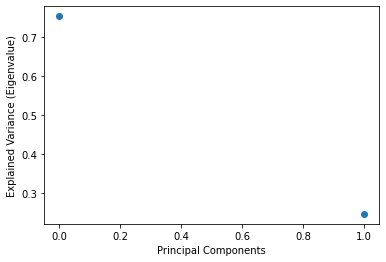

In [32]:
plt.scatter(np.arange(len(pca_eigenvalues)), pca_eigenvalues)
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance (Eigenvalue)")
plt.show()

In [36]:
n_pca = pca_eigen_df[pca_eigen_df['eig_cum'] <= 2]
n_pca = n_pca.shape[0]

In [37]:
pca_components_df = pd.DataFrame(pca_components)

In [38]:
X = pca_components_df.iloc[:,:n_pca]
X.shape

(158, 2)

In [39]:
inertias = []
K = range(1, 100)

for k in K:
    model = KMeans(n_clusters = k, random_state = 100)
    model.fit(X)
    inertias.append(model.inertia_)

C:\Users\Mondello\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


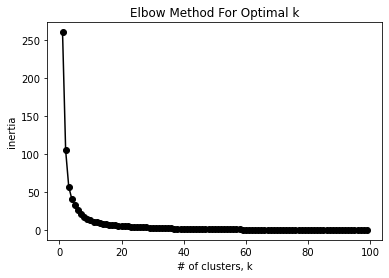

In [40]:
plt.plot(K, inertias, '-o', color='black')
plt.xlabel('# of clusters, k')
plt.ylabel('inertia')
plt.title('Elbow Method For Optimal k')

plt.show()

In [41]:
n = optimal_number_of_clusters(inertias)
print("Optimal number of clusters: ", n)

Optimal number of clusters:  9


In [43]:
km = KMeans(n_clusters = n)
km = km.fit(X)

In [46]:
OPTIONAL = True
execution = date.today().strftime('%Y-%m-%d')

closest = pairwise_distances_argmin(km.cluster_centers_, X)
representatives = []

try:
    os.makedirs(os.path.join(project_dir + "/data/" + "clusters", execution))
except OSError:
    print ("Creation of the directory %s failed" % execution)
else:
    print ("Successfully created the directory %s " % execution)

for i in enumerate(closest):
    traj_index = int((i[1]-1) / traj.n_frames)
    frame_index = i[1]-(traj_index * traj.n_frames)

    n_cluster = str(i[0])
    
    representatives.append([traj_index, frame_index, i[1]])
    print(f"Closest conformation inside cluster {n_cluster} can be found in trajectory {traj_index} frame {frame_index}, (index {i[1]})")

    if OPTIONAL:   
        convert_command = f"mdconvert {trajfile} -t {topfile} -o {project_dir}/data/clusters/{execution}/PCA_in_cluster_{n_cluster}_{frame_index}.pdb -i {frame_index}"        
        print(convert_command)

        call(convert_command, shell = True)

Creation of the directory 2021-07-14 failed
Closest conformation inside cluster 0 can be found in trajectory 0 frame 91, (index 91)
mdconvert C:\Users\data\Crystals.xtc -t C:\Users\data\REFprot.pdb -o C:\Users\data\/data/clusters/2021-07-14/PCA_in_cluster_0_91.pdb -i 91
Closest conformation inside cluster 1 can be found in trajectory 0 frame 143, (index 143)
mdconvert C:\Users\data\Crystals.xtc -t C:\Users\data\REFprot.pdb -o C:\Users\data\/data/clusters/2021-07-14/PCA_in_cluster_1_143.pdb -i 143
Closest conformation inside cluster 2 can be found in trajectory 0 frame 131, (index 131)
mdconvert C:\Users\data\Crystals.xtc -t C:\Users\data\REFprot.pdb -o C:\Users\data\/data/clusters/2021-07-14/PCA_in_cluster_2_131.pdb -i 131
Closest conformation inside cluster 3 can be found in trajectory 0 frame 102, (index 102)
mdconvert C:\Users\data\Crystals.xtc -t C:\Users\data\REFprot.pdb -o C:\Users\data\/data/clusters/2021-07-14/PCA_in_cluster_3_102.pdb -i 102
Closest conformation inside cluster 

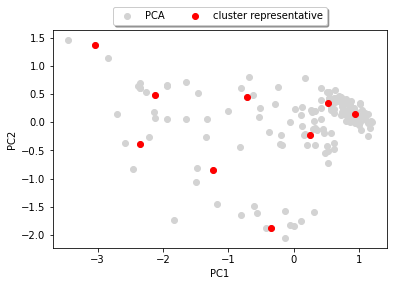

In [47]:
plt.scatter(pca_components[:,0], pca_components[:,1], c="lightgrey")
plt.xlabel("PC1")
plt.ylabel("PC2")

[plt.scatter(pca_components[yr[2],0], pca_components[yr[2],1], c="red") for yr in representatives]

plt.legend(["PCA", "cluster representative"], loc='upper center', bbox_to_anchor=(0.5, 1.13), fancybox=True, shadow=True, ncol=5)

plt.show()

[[ 0.9501112   0.12265314]
 [-2.4621782  -0.339166  ]
 [-1.3368783  -0.9463742 ]
 [ 0.24853289 -0.23966995]
 [ 0.55606025  0.35893694]
 [-2.0468504   0.46483558]
 [-0.23768084 -1.7402915 ]
 [-3.1141686   1.3260323 ]
 [-0.67210555  0.39366534]]


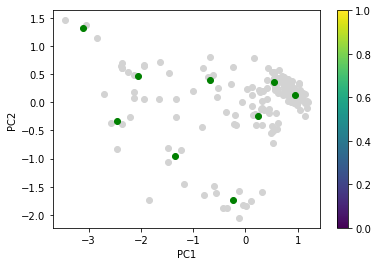

In [48]:
cc = km.cluster_centers_
print(cc)

#plotting all elements
plt.scatter(pca_components_df.iloc[:, 0], pca_components_df.iloc[:, 1], c = "lightgrey")
plt.xlabel("PC1")
plt.ylabel("PC2")

# plotting cluster centers
plt.scatter(cc[:, 0], cc[:, 1], c="green") 
plt.colorbar()
plt.show()